## 1. Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataset_utils import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
ICOSEG_SUBSET_80_PATH = '../datasets/icoseg/subset_80'

## 2. Load icoseg_subset_80 (val split)

In [4]:
_, val, _ = load_icoseg_subset_80()
val_images, val_masks = val

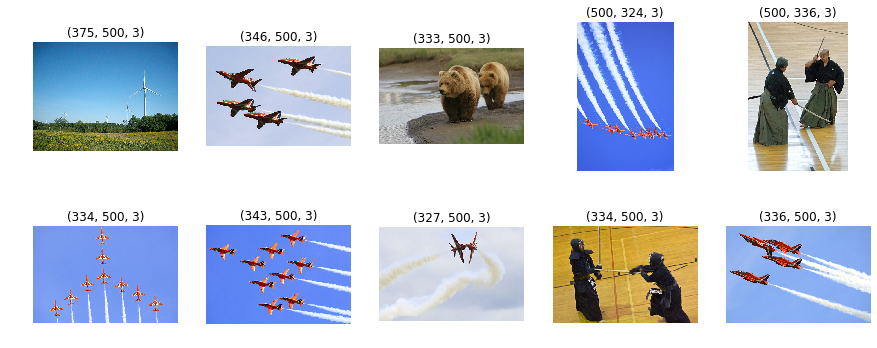

In [5]:
plt.figure(figsize=(15, 6))
for idx, img in enumerate(val_images):
    plt.subplot(2, 5, idx + 1)
    plt.title(f'{img.shape}')
    plt.axis('off')
    plt.imshow(img)

## 3. Crop image (with padding)

In [6]:
def crop_image(img, patch_h=256, patch_w=256):
    patch_shape = (patch_h, patch_w, 3)
    if img.ndim == 2:
        img = img[:,:,np.newaxis]
        patch_shape = (patch_h, patch_w, 1)
        
    row_pad = (patch_shape[0] - (img.shape[0] % patch_shape[0])) % patch_shape[0]
    col_pad = (patch_shape[1] - (img.shape[1] % patch_shape[1])) % patch_shape[1]
    
    img_pad = np.pad(img, [(0, row_pad), (0, col_pad), (0, 0)], 'constant')
    
    rows_start = range(0, img_pad.shape[0], patch_shape[0])
    cols_start = range(0, img_pad.shape[1], patch_shape[1])
    
    patches = np.zeros([len(rows_start), len(cols_start), *patch_shape],
                       dtype=np.uint8)
    
    for i, row in enumerate(rows_start):
        for j, col in enumerate(cols_start):
            patches[i][j] = img_pad[row:row + patch_shape[0],
                                    col:col + patch_shape[1],
                                    :]
    
    return patches.squeeze()

In [7]:
def grid_vis_for_crop_and_merge(img, img_patches, mask, mask_patches):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('image')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title('mask')
    plt.axis('off')
    plt.imshow(mask, cmap='gray')

    img_patches_num = img_patches.shape[0] * img_patches.shape[1]
    plt.figure(figsize=(12.5, 5))

    for i in range(img_patches.shape[0]):
        for j in range(img_patches.shape[1]):
            plt.subplot(img_patches.shape[0],
                        2 * img_patches.shape[1],
                        i * img_patches_num + j + 1)
            plt.title(f'img_patches[{i}][{j}]')
            plt.axis('off')
            plt.imshow(img_patches[i][j])

            plt.subplot(img_patches.shape[0],
                        2 * img_patches.shape[1],
                        i * img_patches_num + img_patches.shape[1] + j + 1)

            plt.title(f'mask_patches[{i}][{j}]')
            plt.axis('off')
            plt.imshow(mask_patches[i][j], cmap='gray')

img.shape: (343, 500, 3)
img.dtype: uint8
img values: [0, 255]

img_patches.shape: (2, 2, 256, 256, 3)
img_patches.dtype: uint8
img_patches values: [0, 255]

mask.shape: (343, 500)
mask.dtype: uint8
mask values: [0, 255]

mask_patches.shape: (2, 2, 256, 256)
mask_patches.dtype: uint8
mask_patches values: [0, 255]


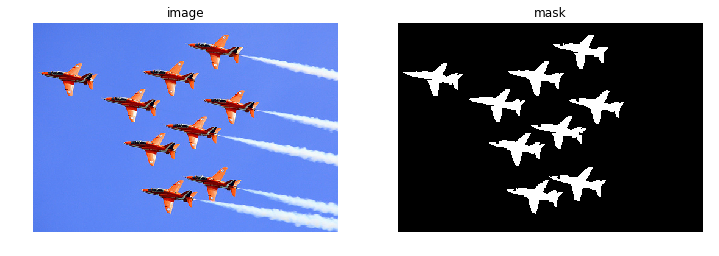

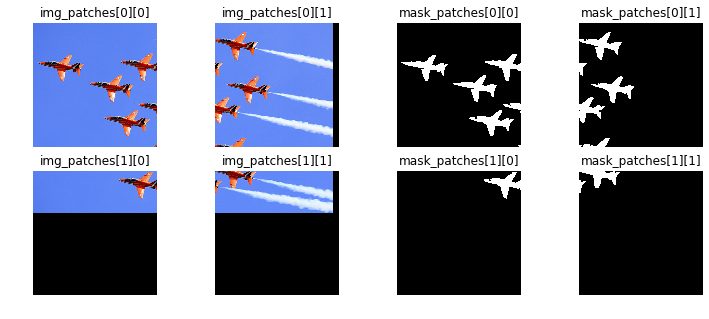

In [8]:
img = val_images[6]
print(f'img.shape: {img.shape}')
print(f'img.dtype: {img.dtype}')
print(f'img values: [{img.min()}, {img.max()}]\n')

img_patches = crop_image(img, patch_h=256, patch_w=256)
print(f'img_patches.shape: {img_patches.shape}')
print(f'img_patches.dtype: {img_patches.dtype}')
print(f'img_patches values: [{img_patches.min()}, {img_patches.max()}]\n')

mask = val_masks[6]
print(f'mask.shape: {mask.shape}')
print(f'mask.dtype: {mask.dtype}')
print(f'mask values: [{mask.min()}, {mask.max()}]\n')

mask_patches = crop_image(mask, patch_h=256, patch_w=256)
print(f'mask_patches.shape: {mask_patches.shape}')
print(f'mask_patches.dtype: {mask_patches.dtype}')
print(f'mask_patches values: [{mask_patches.min()}, {mask_patches.max()}]')

grid_vis_for_crop_and_merge(img, img_patches, mask, mask_patches)

## 4. Merge patches

In [9]:
print(img_patches.shape)
print(mask_patches.shape)

(2, 2, 256, 256, 3)
(2, 2, 256, 256)


In [10]:
def merge_patches(patches, img_h, img_w):
    # combine patches
    img_pad_h = patches.shape[0] * patches.shape[2]
    img_pad_w = patches.shape[1] * patches.shape[3]
    
    patches = np.moveaxis(patches, 2, 1)
    img_pad = patches.reshape([img_pad_h, img_pad_w, -1])
    
    # remove padding
    img = img_pad[:img_h, :img_w, :].squeeze()
    
    return img

img.shape: (343, 500, 3)

img_patches.shape: (2, 2, 256, 256, 3)
img_patches.dtype: uint8
img_patches values: [0, 255]

img.shape: (343, 500, 3)
img.dtype: uint8
img values: [0, 255]

mask_patches.shape: (2, 2, 256, 256)
mask_patches.dtype: uint8
mask_patches values: [0, 255]

mask.shape: (343, 500)
mask.dtype: uint8
mask values: [0, 255]



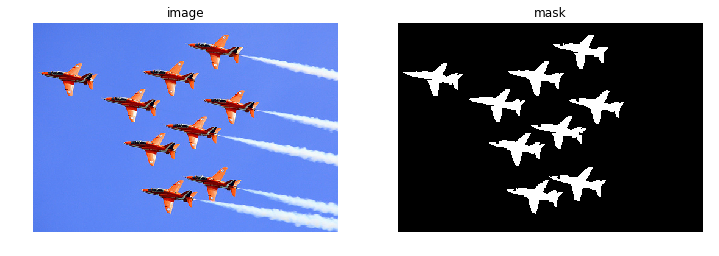

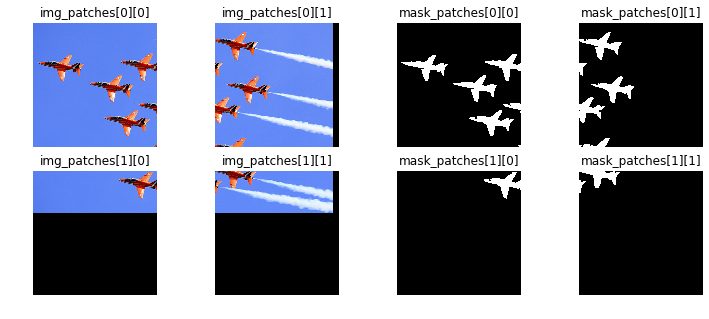

In [11]:
img_h, img_w, _ = img.shape
print(f'img.shape: {img.shape}\n')

# img_patches
print(f'img_patches.shape: {img_patches.shape}')
print(f'img_patches.dtype: {img_patches.dtype}')
print(f'img_patches values: [{img_patches.min()}, {img_patches.max()}]\n')

img_after_merge = merge_patches(img_patches, img_h=img_h, img_w=img_w)
print(f'img.shape: {img.shape}')
print(f'img.dtype: {img.dtype}')
print(f'img values: [{img.min()}, {img.max()}]\n')

# mask_patches
print(f'mask_patches.shape: {mask_patches.shape}')
print(f'mask_patches.dtype: {mask_patches.dtype}')
print(f'mask_patches values: [{mask_patches.min()}, {mask_patches.max()}]\n')

mask_after_merge = merge_patches(mask_patches, img_h=img_h, img_w=img_w)
print(f'mask.shape: {mask.shape}')
print(f'mask.dtype: {mask.dtype}')
print(f'mask values: [{mask.min()}, {mask.max()}]\n')

grid_vis_for_crop_and_merge(img_after_merge, img_patches, mask_after_merge, mask_patches)